In [3]:
import math
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [659]:
class Model():
    def __init__(self, n_mun=2, mul_com=3):
        print("model initialzied")
        self.tick = 0
        self.name = "model"
        self.log = []
        self.log.append([self.tick, self.name, "initialized"])
        
        self.n_mun = n_mun
        self.mun_list = []
        self.mun_pop = 75, 500
        
        self.n_com = n_mun * max(3, mul_com)
        self.com_list = []
        
        self.house_type = ["single", "couple", "family", "retired"]
        self.distribution = [0.3, 0.3, 0.2, 0.2]
        self.distribution = np.array(self.distribution).cumsum()
        self.weights = [0.95, 1.05, 1.10, 0.9]
        self.weights = dict(zip(self.house_type, self.weights))
        self.percep_range = 0.2
        self.know_range = 0.3
        self.max_perc = 0.5
        self.increase_perc = self.max_perc / 120
        self.max_know = 1.0
        self.increase_know = self.max_know / 120
        
        self.final_target = 0.2
        self.target_mean = 0.10
        self.target_std = 0.05
        self.amb_min = 0.15
        self.amb_mean = 0.3
        self.amb_std = 0.2
        
        self.campaign_bud_prop = 0.5
        self.infra = 0.5
        
        self.cap_min = 300
        self.cap_mean = 600
        self.cap_std = 300
        self.cap_max = 900
        self.technology = 0.2
        self.tech_std = 0.1
        self.tech_min = 0.05
        self.fine_mean = 0.02
        
        # post requests from municipalities, offers from companies
        self.requests = []
        self.offers = []
        
    def setup(self):
        print("model setup")
        self.populate()
        self.cal_avg_tech()
        self.cal_avg_target()
        
    def populate(self):
        for i in range(self.n_mun):
            m = self.Municipality(i, self)
            self.mun_list.append(m)
        for i in range(self.n_com):
            c = self.Company(i, self)
            self.com_list.append(c)
            
    def shuffle(self):
        random.shuffle(self.mun_list)
        random.shuffle(self.com_list)
        
    def update(self):
        self.tick += 1
        self.shuffle()
        
        for m in self.mun_list:
            m.update()
            
        for c in self.com_list:
            c.update()
            
        self.cal_avg_target()
        self.cal_avg_tech()
            
    def selection_on(self):
        self.shuffle()
        for m in self.mun_list:
            m.select_bidder()
            
    def close_bid(self):
        log = " ".join([self.name, "close bid."])
        self.log.append([self.tick, self.name, log])
        
        self.requests = []
        self.offers = []
        
        self.shuffle()
        self.tick -= 1
        self.update()
    
    def cal_avg_target(self):
        targets = []
        for m in self.mun_list:
            targets.append(m.target)
        self.targets = targets
    
    def cal_avg_tech(self):
        techs = []
        for c in self.com_list:
            techs.append(c.technology)
        self.avg_tech = sum(techs) / len(techs)
    
    def cal_avg_require(self):
        self.avg_req = np.array(self.requests)[:,1].mean()
            
    class Municipality():
        def __init__(self, i, model):
            self.unique_id = i
            self.name = " ".join(["Municipality",str(i)])
            self.model = model
            self.provider = None
            self.contract_counter = 0

            self.infra_central = self.model.infra > random.random()
            
            # assign population and target
            self.n_pop = random.randint(*self.model.mun_pop)            
            target = min(random.gauss(self.model.target_mean, self.model.target_std), self.model.max_perc * self.model.max_know)
            self.target = round(target, 4)
            self.target_history = np.zeros(241)
            self.target_history[0] = self.target
            self.ambitious = max(self.model.amb_min, random.gauss(self.model.amb_mean, self.model.amb_std))
            
            log = " ".join(["population:", str(self.n_pop), "target", str(round(self.target,2)),"is created"])
            self.model.log.append([self.model.tick, self.name, log])

            self.house_list = []
            self.waste_history = []
            self.fine_history = []
            self.fine = 0
            self.have_fine = False # by default, it starts from False

            # populate its households
            self.populate()
            # aggregate wastes
            self.aggr_wastes()
            # set budget
            self.set_budget()
            
        def populate(self):
            for i in range(self.n_pop):
                h = self.Household(i, self)
                self.house_list.append(h)
            
        def aggr_wastes(self):
            waste, plastic, recycle = 0, 0, 0
            for h in self.house_list:
                waste += h.waste
                plastic += h.plastic
                recycle += h.recycle

            self.waste = round(waste,2)
            self.plastic = round(plastic,2)
            self.recycle = round(recycle,2)
            
            self.plastic_prop = round(self.plastic / self.waste, 3)
            self.recycle_prop = round(self.recycle / self.waste, 3)
            self.recycle_in_plastic_prop = round(self.recycle / self.plastic, 3)

            self.waste_history.append([self.waste, self.plastic, self.recycle, self.plastic_prop, self.recycle_prop])
            
            log = " ".join([self.name, "aggregates wastes, plastic, recycle:"])
            self.model.log.append([self.model.tick, self.name, log])
            log = " ".join([str(self.waste), str(self.plastic), str(self.recycle)])
            self.model.log.append([self.model.tick, self.name, log])
            
            self.expense_waste = self.waste
            
        def set_budget(self):
            # assign basic and campaign budget
            # 1 money unit is required to process 1 ton of waste
            self.basic_bud = self.waste * 1.0
            self.campaign_bud = self.basic_bud * self.model.campaign_bud_prop
#             self.expense_camp = self.campaign_bud / 240
            
            self.account_book = np.zeros([3, 241])
            self.account_book[0,0] = self.basic_bud * 240
            self.account_book[1,0] = self.campaign_bud * 240
            
            log = " ".join([self.name, "set budget", str(round(self.basic_bud,2)), str(round(self.campaign_bud,2))])
            self.model.log.append([self.model.tick, self.name, log])
            
        def update(self):
            log = " ".join([self.name, "update"])
            self.model.log.append([self.model.tick, self.name, log])
            
            if self.provider == None: #initialize
                self.bid_on()
            elif self.contract_counter == 0: # when contract ends
                self.terminate_contract()
                self.bid_on()
            else: # normal procedure
                self.normal_proceed()
                
        def normal_proceed(self):
            for h in self.house_list:
                h.produce()
            self.contract_counter -= 1
            self.aggr_wastes()
            self.check_target_met()
            if not self.target_met:
                self.campaign()
            self.accounting()
            if self.model.tick%12 == 0:
                self.adjust_target()
            self.target_history[self.model.tick] = self.target
    
        def bid_on(self):
            log = " ".join([self.name, "start bidding process"])
            self.model.log.append([self.model.tick, self.name, log])
            self.create_requests()
            
        def create_requests(self):
            X = round(self.waste, 2)
            x = round(self.target,2)
            self.model.requests.append([self.unique_id, X, x])
            
            log = " ".join([self.name, "create request", str(X), str(x)])
            self.model.log.append([self.model.tick, self.name, log])
            
            # final requester informs system to calculate avg_requirement
            if self == self.model.mun_list[-1]:
                self.model.cal_avg_require()

                log = " ".join([self.name, "final request, initiate offer"])
                self.model.log.append([self.model.tick, self.name, log])
            
        def select_bidder(self):
            price_thresh = 1.1
            
            waste = self.waste
            adj_waste = waste
            target = self.target
            adj_target = target

            offers = pd.DataFrame(self.model.offers, columns = ["com", "capacity", "technology", "price", "fine", "time", "period"])
            offers["mun"] = self.unique_id
            contracts = []
            filtered1 = offers.copy()

            while waste > 0:
                filtered1 = filtered1[filtered1["capacity"] > adj_waste]
                while len(filtered1) == 0:
                    adj_waste = adj_waste * 0.5
                    filtered1 = offers[offers["capacity"] > adj_waste]

                filtered2 = filtered1.copy()
                filtered2 = filtered1[filtered1["technology"] > adj_target]
                while len(filtered2) == 0:
                    adj_target = adj_target * 0.8
                    filtered2 = filtered1[filtered1["technology"] > adj_target]

                scores = filtered2[["technology","price","fine"]].values

                for i in range(scores.shape[1]):
                    scores[:, i] = scores[:, i].max()/scores[:, i]
                scale = MinMaxScaler([0.9, 1.0])
                winner = scale.fit_transform(scores).sum(axis=1).argmax()
                winner = filtered2.iloc[winner].to_dict()
                contracts.append(winner)
                offers = offers[offers["com"] != winner["com"]]    
                waste -= winner["capacity"]
                filtered1 = offers.copy()
                
            # update the offers (excluding winners)
            self.model.offers = offers    
            self.contracts = contracts
            self.setup_contract()
            
        def setup_contract(self):
            log = " ".join([self.name, "(%s, %s)"%(self.waste, self.target),"select offer(s):", str(self.contracts)])
            self.model.log.append([self.model.tick, self.name, log])
            self.contract_counter = 36
            
            self.give_contract()
            
            # the last municipality closes bid
            if self == self.model.mun_list[-1]:
                self.model.close_bid()

        def give_contract(self):
            log = " ".join([self.name, "gives contract"])
            self.model.log.append([self.model.tick, self.name, log])            

            self.provider = []
            winners = []
            for contract in self.contracts:
                com_id = contract["com"]
                for com in self.model.com_list:
                    if com.unique_id == com_id:
                        winners.append(com_id)
                        self.provider.append(com)
                        com.receive_contract(self)
                        
        def terminate_contract(self):
            log = " ".join([self.name, "terminates contract"])
            self.model.log.append([self.model.tick, self.name, log])
            for com in self.provider:
                com.terminate_contract()
                
        def check_target_met(self):
            self.target_met = self.recycle/self.waste > self.target
            log = " ".join([self.name, "check whether the target is met:", str(self.target_met)])
            self.model.log.append([self.model.tick, self.name, log])
            if self.target_met & (self.model.tick == 1):
                self.expense_camp = 0
        
        def campaign(self):
            time_remain = 240 - self.model.tick
            budget_remain = self.account_book[1, self.model.tick-1]
            self.expense_camp = budget_remain / time_remain
            
            maxlim_ref = self.basic_bud * 0.5
            self.camp_effect = self.campaign_bud / maxlim_ref

#             self.expense_camp = self.campaign_bud / 240
            
            random.shuffle(self.house_list)
            house_level = np.zeros([2, self.n_pop])
            for i, h in enumerate(self.house_list):
                h.increase_perc(self.camp_effect)
                h.increase_know(self.camp_effect)
                house_level[0,i] = h.perception
                house_level[1,i] = h.knowledge                
            self.house_level = house_level
            after_perc = round(house_level[0].mean(), 3)
            after_know = round(house_level[1].mean(), 3)

            log = " ".join([self.name, "campaign →", "%s, %s"%(after_perc, after_know)])
            self.model.log.append([self.model.tick, self.name, log])
            
        def adjust_target(self):
            self.ref_target = np.percentile(self.model.targets, q = self.ambitious*100)
            if self.target < self.ref_target:
                self.target = min(self.model.final_target, self.ref_target)
            elif self.target == max(self.model.targets):
                self.target += 0
            else:
                time_remain = 240 - self.model.tick
                if time_remain != 0:
                    gap = self.model.final_target - self.target
                    incremental = gap / time_remain
                    self.target += incremental * 12
            log = " ".join([self.name, "adjust target to %s"%self.target])
            self.model.log.append([self.model.tick, self.name, log])
            
        def accounting(self):
            expense_waste = self.expense_waste
            log = " ".join([self.name, "waste: %s, expense: %s"%(self.waste, expense_waste)])
            self.model.log.append([self.model.tick, self.name, log])

            self.account_book[0,self.model.tick] = self.account_book[0,self.model.tick-1] - expense_waste
            self.account_book[1,self.model.tick] = self.account_book[1,self.model.tick-1] - self.expense_camp
            self.account_book[2,self.model.tick] = self.fine
                
            
        class Household():
            def __init__(self, i, municipality):
                # assign id, mun, model, name
                self.unique_id = i
                self.municipality = municipality
                self.municipality_id = municipality.unique_id
                self.model = self.municipality.model
                self.name = " ".join(["Household", str(self.municipality_id), str(i)])
                
                # assign type and weight
                dice = random.random()
                type_ = np.where(model.distribution > dice)[0].min()
                self.type = self.model.house_type[type_]
                self.weight = self.model.weights[self.type]
                
                # assign perception and knowledge
                self.perception = max(0, random.gauss(self.model.percep_range, self.model.percep_range/10))
                self.perc_history = []
                self.perc_history.append(self.perception)
                
                self.knowledge = max(0, random.gauss(self.model.know_range, self.model.know_range/10))
                self.know_history = []
                self.know_history.append(self.knowledge)
                
                # produce the first wastes
                self.produce()
                
            def produce(self):
                # produce waste, plastic, recycle
                x = self.model.tick
                self.waste = self.weight * (40 - 0.04 * x - math.exp(-0.01*x) * math.sin(0.3*x))/12
                self.plastic = self.waste * self.perception
                self.recycle = self.plastic * self.knowledge
                
            def increase_perc(self, effect):
                if self.perception < self.model.max_perc:
                    self.perception += self.model.increase_perc*effect
                else:
                    self.perception = self.model.max_perc
                self.perc_history.append(self.perception)
                
            def increase_know(self, effect):
                if self.knowledge < self.model.max_know:
                    self.knowledge += self.model.increase_know*effect
                else:
                    self.knowledge = self.model.max_know
                self.know_history.append(self.knowledge)

    class Company():
        
        def __init__(self, i, model):
            self.unique_id = i
            self.name = " ".join(["Company",str(i)])
            self.model = model
            
            self.client = None
            self.win_contract = False
            technology = max(random.gauss(self.model.technology, self.model.tech_std), self.model.tech_min)
            self.technology = round(technology,3)
            self.tech_arr = []
            self.capacity = min(max(self.model.cap_min,
                                    random.gauss(self.model.cap_mean, self.model.cap_std)),
                                self.model.cap_max)
            self.cap_arr = []
            
            self.profits = np.zeros([2,241])
            self.invest_on = False
            
            log = " ".join(["capacity", str(self.capacity), "tech", str(round(self.technology,2)), "is created"])
            self.model.log.append([self.model.tick, self.name, log])
            
        def update(self):
            log = " ".join([self.name, "update"])
            self.model.log.append([self.model.tick, self.name, log])
            
            if self.client == None:
                if len(self.model.requests) != 0:
                    self.check_requests()
                else:
                    self.wait()
                    self.calculate_profit() # no profit, only for the sake of recording
                    self.invest()
            else:
                self.check_waste()
                self.collect()
                self.claim_fine()
                self.calculate_profit()
                self.invest()
                
            self.tech_arr.append(self.technology)
            self.cap_arr.append(self.capacity)
            
        def check_requests(self):
            log = " ".join([self.name, "makes an offer"])
            self.model.log.append([self.model.tick, self.name, log])
            
            self.make_offer()
            
        def make_offer(self):
            self.price = round(self.capacity * self.technology)
            self.fine = round(max(0,random.gauss(self.model.fine_mean, self.model.fine_mean/10)), 4)
            period = 36
            self.offer = [self.unique_id, self.capacity, self.technology, self.price, self.fine, self.model.tick, period]
            self.model.offers.append(self.offer)
            
            log = " ".join([self.name, "creates offers"])
            self.model.log.append([self.model.tick, self.name, log])
            
            # the final bidder informs the system
            if self == self.model.com_list[-1]:
                log = " ".join([self.name, "final offer, initiate selection"])
                self.model.log.append([self.model.tick, self.name, log])
                self.model.selection_on()
                
        def receive_contract(self, mun):
            log = " ".join([self.name, "receives contract from", mun.name])
            self.model.log.append([self.model.tick, self.name, log])            
            self.client = mun
            self.win_contract = True
            
        def terminate_contract(self):
            self.client = None
            self.win_contract = False
                        
        def wait(self):
            self.plastic_to_process = 0
            log = " ".join([self.name, "no client, no requests, thus: wait"])
            self.model.log.append([self.model.tick, self.name, log])
            
        def check_waste(self):
            plastic = round(self.client.plastic)
            min_req = round(self.capacity * 0.2)
            
            log = " ".join([self.name, "min_req vs. actual plastic volume:", str(min_req), "|", str(plastic)])
            self.model.log.append([self.model.tick, self.name, log])
            
            self.claim = min_req > plastic
            
        def claim_fine(self):
            if self.claim:
                self.client.have_fine = True
                fine = round(self.price*self.fine,2)
                log = " ".join([self.name, "claim fine to", self.client.name, str(fine)])
                self.model.log.append([self.model.tick, self.name, log])
            else:
                self.client.have_fine = False
                fine = 0
                log = " ".join([self.name, "no fine to", self.client.name])
                self.model.log.append([self.model.tick, self.name, log])
            self.client.fine = fine
            fine = dict(zip(["from", "time", "fine"], [self.unique_id, self.model.tick, fine]))
            self.client.fine_history.append(fine)
                
        def collect(self):
            waste = self.client.waste
            plastic = self.client.plastic
            
            if waste >= self.capacity:
                collect = self.capacity
                collect_p = self.capacity * self.client.plastic_prop
                collect = round(collect,2)
                collect_p = round(collect_p,2)
            
                self.client.waste -= self.capacity
                self.client.plastic -= collect_p
                
            elif waste < self.capacity:
                collect = waste
                collect_p = waste * self.client.plastic_prop
                collect = round(collect,2)
                collect_p = round(collect_p,2)

                self.client.waste = 0
                self.client.plastic = 0
            
            self.plastic_to_process = collect_p * self.client.recycle_in_plastic_prop
            
            log = " ".join([self.name, "collect waste: %s"%collect, "change: %s→%s"%(str(waste), str(self.client.waste))])
            self.model.log.append([self.model.tick, self.name, log])

            log = " ".join([self.name, "collect plastic: %s"%collect_p, "change: %s→%s"%(str(plastic), str(self.client.plastic))])
            self.model.log.append([self.model.tick, self.name, log])
                
        def calculate_profit(self):
            if self.client == None:
                coff = None
                profit = 0
            else:
                if self.client.infra_central:
                    coff = 1
                else:
                    coff = 0.5
                profit = round(coff * self.plastic_to_process * self.technology, 2)
            self.profits[0, self.model.tick] = coff
            self.profits[1, self.model.tick] = profit
                    
        def invest(self):
            if not self.invest_on:
                self.low_tech = self.technology < self.model.avg_tech
                self.low_cap = self.capacity < self.model.avg_req * 0.8

                investment_decision = (not self.win_contract) | (self.low_tech) | (self.low_cap)

                # 3 reasons for making investment
                reason = []
                reasons = []
                if self.low_tech:
                    reason.append("low_tech(%s, %s)"%(self.technology, self.model.avg_tech))
                    reasons.append("tech")

                if self.low_cap:
                    reason.append("low_cap(%s, %s)"%(self.capacity, self.model.avg_req))
                    reasons.append("capacity")

                if not self.win_contract:
                    reason.append("fail_win_contract")
                    reasons.append("fail_win_contract")

                if investment_decision:
                    self.invest_on = True
                    self.invest_counter = 11
                    self.investment_reason = reason
                    self.investment_reasons = reasons
                    
                    log = " ".join([self.name, "Invest on Technology, Reason:", ";".join(self.investment_reason)])
                    self.model.log.append([self.model.tick, self.name, log])
                    
            else: # investment on
                if self.invest_counter != 0:
                    self.invest_counter -= 1
                else:
                    self.investment_complete()
                    
        def investment_complete(self):
            self.invest_on = False
            log = " ".join([self.name, "Invest Complete"])
            self.model.log.append([self.model.tick, self.name, log])
            
            if "tech" in self.investment_reasons:
                self.increase_tech()

            if "capacity" in self.investment_reasons:
                self.increase_cap()
                
            if "fail_win_contract" in self.investment_reasons:
                if random.random() > 0.5:
                    self.increase_tech()
                else:
                    self.increase_cap()
                
        def increase_tech(self):
            # 1%~5% increase of capacity as a result of investment
            old = self.technology
            self.technology += random.uniform(0.01, 0.05)

            log = " ".join([self.name, "tech increases from %s to %s"%(old, self.technology)])
            self.model.log.append([self.model.tick, self.name, log])
            
        def increase_cap(self):
            # 5~10% increase of capacity as a result of investment
            old = self.capacity
            self.capacity *= random.uniform(1.05, 1.10)
            
            log = " ".join([self.name, "capacity increases from %s to %s"%(old, self.capacity)])
            self.model.log.append([self.model.tick, self.name, log])
            
model = Model(n_mun=10)
model.infra = 0.2
model.setup()
for i in range(240):
    model.update()

model initialzied
model setup


In [660]:
pd.DataFrame(model.log).tail()

,0,1,2
34692,240,Company 17,"Company 17 no client, no requests, thus: wait"
34693,240,Company 26,Company 26 update
34694,240,Company 26,"Company 26 no client, no requests, thus: wait"
34695,240,Company 12,Company 12 update
34696,240,Company 12,"Company 12 no client, no requests, thus: wait"


In [661]:
for i,mun in enumerate(model.mun_list):
    print(mun.ambitious)

0.39264745939226736
0.15
0.7576790390507551
0.386686979614044
0.2755747053787674
0.47257404684979815
0.25490276885847224
0.3821673728281581
0.4016037108835688
0.4306796445318579


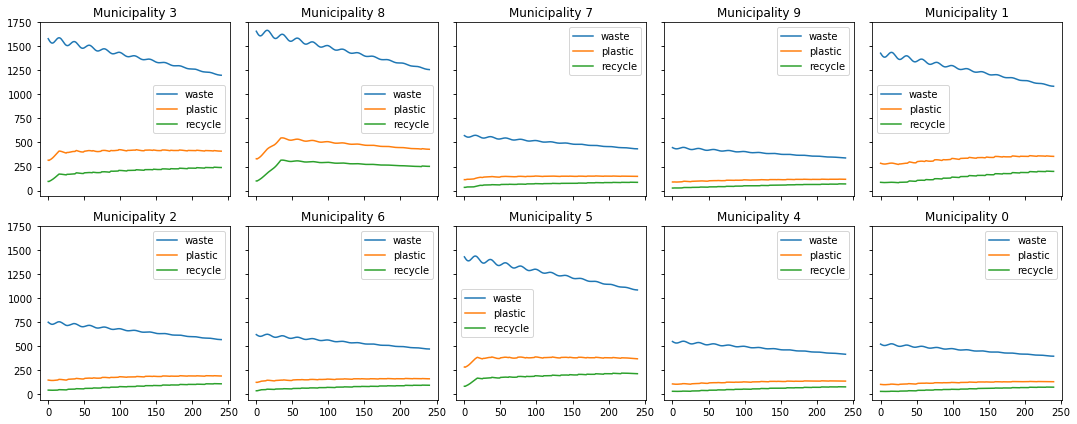

In [662]:
ncols=5
if len(model.mun_list)%5 != 0:
    nrows=len(model.mun_list)//5+1
else:
    nrows=len(model.mun_list)//5

fig,axes = plt.subplots(ncols=ncols, nrows=nrows,
                        sharex=True, sharey=True,
                        figsize=(ncols*3, nrows*3))

if nrows == 1:
    locs = np.arange(ncols)
else:
    locs = list(itertools.product(range(nrows), range(ncols)))
    
for i,mun in enumerate(model.mun_list):
    loc=locs[i]
    ax=axes[loc]
    waste_history = pd.DataFrame(np.array(mun.waste_history)[:, :3], columns=["waste", "plastic", "recycle"])
    waste_history.plot(ax=ax)
    ax.set_title(mun.name)
plt.tight_layout()

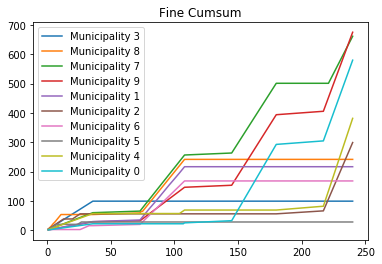

In [663]:
for mun in model.mun_list:
    plt.plot(pd.DataFrame(mun.fine_history).groupby("time").sum().cumsum()["fine"],label=mun.name)
plt.title("Fine Cumsum")
plt.legend()

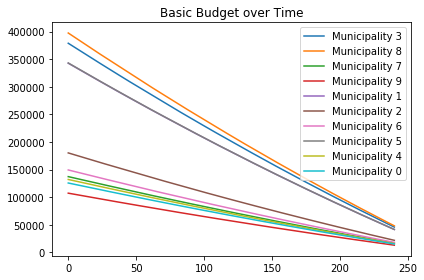

In [664]:
# plt.figure(figsize = (10,5))
for i,mun in enumerate(model.mun_list):
#     plt.subplot(len(model.mun_list),2,i+1)
    plt.plot(mun.account_book.T[:,0], label = mun.name)
plt.legend()
plt.title("Basic Budget over Time")
plt.tight_layout()

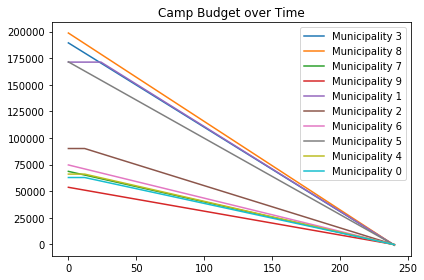

In [665]:
# plt.figure(figsize = (10,5))
for i,mun in enumerate(model.mun_list):
#     plt.subplot(len(model.mun_list),2,i+1)
    plt.plot(mun.account_book.T[:,1], label = mun.name)
plt.legend()
plt.title("Camp Budget over Time")
plt.tight_layout()

In [666]:
for i,mun in enumerate(model.mun_list):
    print(mun.expense_waste)

1198.5
1257.23
434.01
339.21
1084.08
569.95
472.24
1085.47
417.68
397.43


In [667]:
for i,mun in enumerate(model.mun_list):
    print(mun.expense_camp)

792.3866108786635
831.2133891212526
286.94560669456007
224.26945606694395
796.7441860465095
396.74008810572906
312.2158995815893
717.6552301255222
290.7488986784128
276.6502202643178


In [668]:
for mun in model.mun_list:
    print(mun.target, mun.target_met)

0.2 True
0.2 True
0.2 True
0.2 True
0.18925792605613578 True
0.193942403725427 True
0.2 True
0.19531578947368422 True
0.1921565715645017 True
0.19305263867723738 True


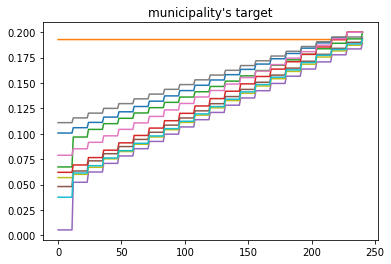

In [669]:
for i, mun in enumerate(model.mun_list):
#     plt.subplot(len(model.mun_list), 1, i+1)
    plt.plot(mun.target_history)
#     plt.plot(np.array(mun.waste_history)[:, -1])
    plt.title("municipality's target")

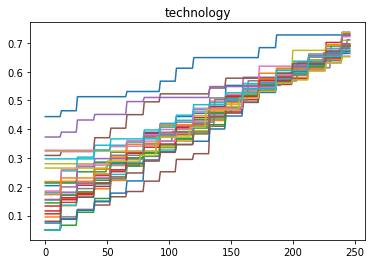

In [670]:
for com in model.com_list:
#     print(com.technology)
    plt.plot(com.tech_arr)
    plt.title("technology")

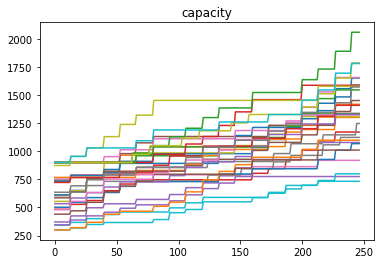

In [671]:
for com in model.com_list:
#     print(com.capacity)
    plt.plot(com.cap_arr)
    plt.title("capacity")

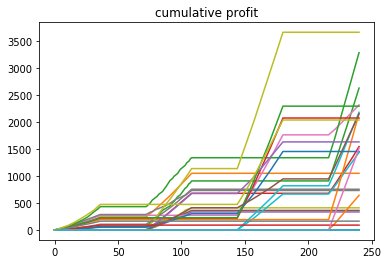

In [672]:
for com in model.com_list:
    plt.plot(com.profits[1].cumsum())
    plt.title("cumulative profit")